## Mango Leaf Disease: Image Classification

Dataset Source: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset

#### Import Necessary Libraries

In [1]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Libraries

In [21]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.23.5
        Pandas: 2.0.0
      Datasets: 2.11.0
  Transformers: 4.27.4
         Torch: 2.0.0


#### Ingest Dataset

In [22]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/current projects/Mango Leaf Disease Dataset/data", 
                        drop_labels=False)

dataset

Resolving data files:   0%|          | 0/4000 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59dd9b84b869d1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
})

#### Split Dataset into Training & Evaluation Datasets

In [23]:
train_eval = dataset['train'].train_test_split(test_size=0.20)

ds = DatasetDict({
    'train': train_eval['train'],
    'eval': train_eval['test']
})

#### Display Information About Dataset Dictionary Splits

In [24]:
print("Training Dataset")
print(f"Training Dataset Information: {ds['train']}")
print(f"First Sample in Training Dataset: {ds['train'][0]}")
print(f"Last Sample in Training Dataset: {ds['train'][-1]}")

print("\nEvaluation Dataset")
print(f"Evaluation Dataset Information: {ds['eval']}")
print(f"First Sample in Evaluation Dataset: {ds['eval'][0]}")
print(f"Last Sample in Evaluation Dataset: {ds['eval'][-1]}")

Training Dataset
Training Dataset Information: Dataset({
    features: ['image', 'label'],
    num_rows: 3200
})
First Sample in Training Dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x320 at 0x7FDFC889FA00>, 'label': 1}
Last Sample in Training Dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x240 at 0x7FDFF8747580>, 'label': 3}

Evaluation Dataset
Evaluation Dataset Information: Dataset({
    features: ['image', 'label'],
    num_rows: 800
})
First Sample in Evaluation Dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x240 at 0x7FDFF87479D0>, 'label': 2}
Last Sample in Evaluation Dataset: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=240x320 at 0x7FDFF8747C40>, 'label': 1}


#### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [5]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font, dill=(0,0,255,1.0))
    
    return grid

#### Display Example Images From Each Class

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59dd9b84b869d1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-0fb0ea42949fc146.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59dd9b84b869d1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-7c2f8c8552e0b51e.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59dd9b84b869d1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-6ef7e6d6f5b21036.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59dd9b84b869d1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-0e1d01d477e481c8.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-0f59d

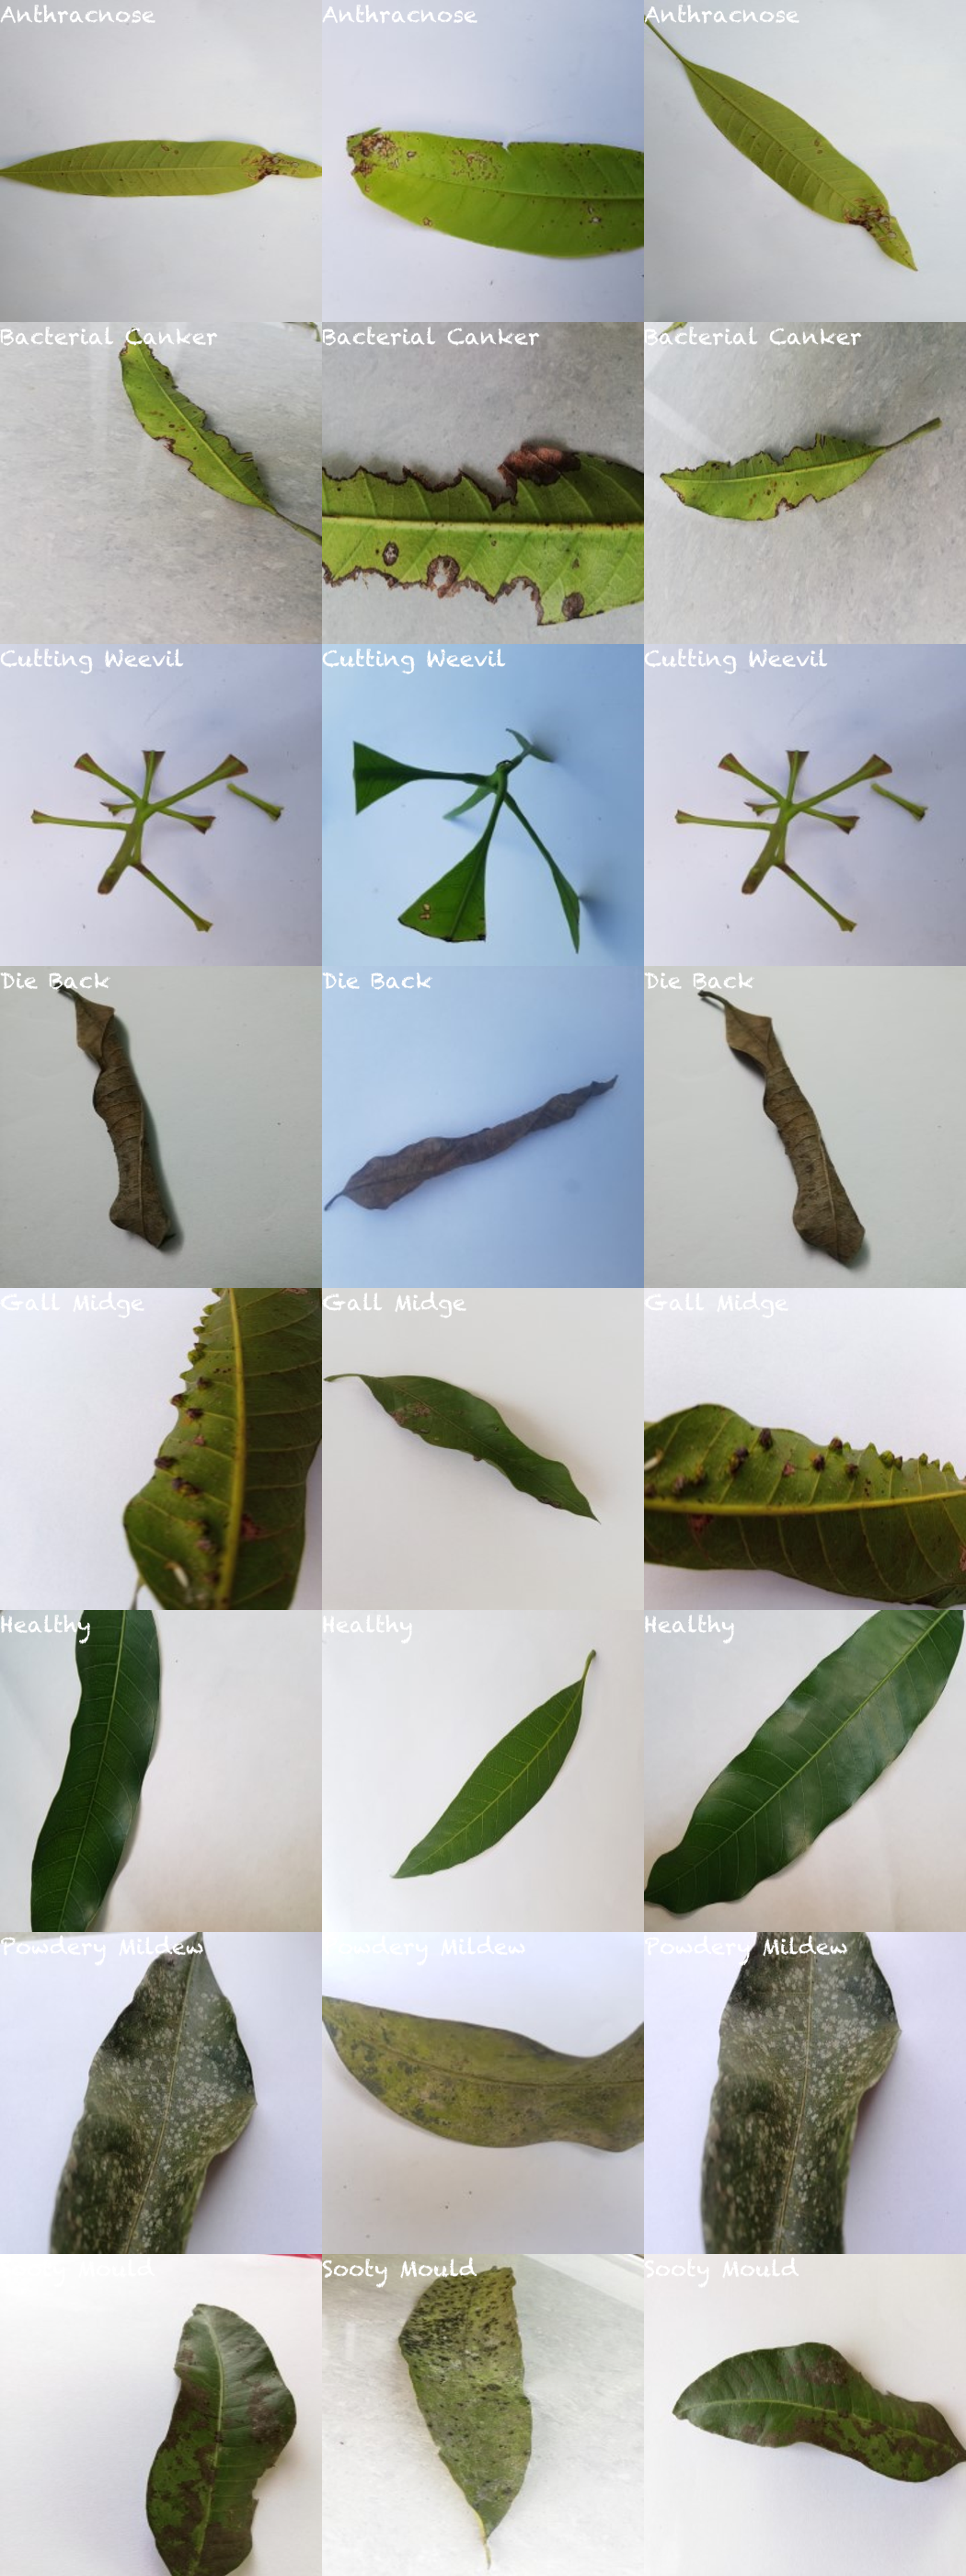

In [6]:
show_grid_of_examples(dataset, seed=42, examples_per_class=3)

#### Basic Values/Constants

In [7]:
MODEL_CKPT = 'google/vit-base-patch16-224-in21k'
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Mango_leaf_Disease"

NUM_OF_EPOCHS = 2

LEARNING_RATE = 2e-4
STEPS = 100

BATCH_SIZE = 16
DEVICE = torch.device("mps")

STRATEGY = "epoch"
REPORTS_TO = 'tensorboard'

#### Load ViT Feature Extractor

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


#### Preprocessing Dataset

In [9]:
def transform(sample_batch):
    # take a list of PIL images and turn them into pixel values
    inputs = feature_extractor([x for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

#### Apply Transform Function to Dataset

In [10]:
prepped_ds = ds.with_transform(transform)

#### Define Data Collator

In [11]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

#### Define Evaluation Metric

In [12]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Load Pretrained Model

In [13]:
labels = dataset['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [14]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="Weighted F1",
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [15]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['eval'],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Mango_leaf_Disease into local empty directory.


#### Train Model

In [16]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

{'loss': 2.0733, 'learning_rate': 0.00019950000000000002, 'epoch': 0.01}
{'loss': 0.4074, 'learning_rate': 0.00015000000000000001, 'epoch': 0.5}
{'loss': 0.0554, 'learning_rate': 0.0001, 'epoch': 1.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.03593560308218002, 'eval_accuracy': 0.99875, 'eval_Weighted F1': 0.9987500325393726, 'eval_Micro F1': 0.99875, 'eval_Macro F1': 0.9987244565924769, 'eval_Weighted Recall': 0.99875, 'eval_Micro Recall': 0.99875, 'eval_Macro Recall': 0.9987373737373737, 'eval_Weighted Precision': 0.9987627551020408, 'eval_Micro Precision': 0.99875, 'eval_Macro Precision': 0.9987244897959184, 'eval_runtime': 386.8904, 'eval_samples_per_second': 2.068, 'eval_steps_per_second': 0.258, 'epoch': 1.0}
{'loss': 0.0262, 'learning_rate': 5e-05, 'epoch': 1.5}
{'loss': 0.0192, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.018915435299277306, 'eval_accuracy': 1.0, 'eval_Weighted F1': 1.0, 'eval_Micro F1': 1.0, 'eval_Macro F1': 1.0, 'eval_Weighted Recall': 1.0, 'eval_Micro Recall': 1.0, 'eval_Macro Recall': 1.0, 'eval_Weighted Precision': 1.0, 'eval_Micro Precision': 1.0, 'eval_Macro Precision': 1.0, 'eval_runtime': 388.3453, 'eval_samples_per_second': 2.06, 'eval_steps_per_second': 0.258, 'epoch': 2.0}
{'train_runtime': 9143.9921, 'train_samples_per_second': 0.7, 'train_steps_per_second': 0.044, 'train_loss': 0.13119665324687957, 'epoch': 2.0}


#### Save Model as Well as Log & Save Metrics of Training Dataset

In [17]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Apr30_22-41-00_Brians-Mac-mini/events.out.tfevents.1682912467.Brians-Mac-mini.67183.0:   0%| …

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Mango_leaf_Disease
   e7442f9..0ee322e  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Mango_leaf_Disease
   0ee322e..07c2829  main -> main



***** train metrics *****
  epoch                    =        2.0
  train_loss               =     0.1312
  train_runtime            = 2:32:23.99
  train_samples_per_second =        0.7
  train_steps_per_second   =      0.044


#### Evaluate Model & Save Metrics

In [18]:
metrics = trainer.evaluate(prepped_ds['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/100 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        2.0
  eval_Macro F1           =        1.0
  eval_Macro Precision    =        1.0
  eval_Macro Recall       =        1.0
  eval_Micro F1           =        1.0
  eval_Micro Precision    =        1.0
  eval_Micro Recall       =        1.0
  eval_Weighted F1        =        1.0
  eval_Weighted Precision =        1.0
  eval_Weighted Recall    =        1.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0189
  eval_runtime            = 0:06:27.56
  eval_samples_per_second =      2.064
  eval_steps_per_second   =      0.258


#### Push Model to Hub (My Profile!)

In [19]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Upload file runs/Apr30_22-41-00_Brians-Mac-mini/events.out.tfevents.1682922500.Brians-Mac-mini.67183.2: 100%|#…

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Mango_leaf_Disease
   07c2829..710350e  main -> main



### Notes & Other Takeaways
****
- 
- 
****

### Citation

- Model Checkpoint
    > @misc{wu2020visual, title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda}, year={2020}, eprint={2006.03677}, archivePrefix={arXiv}, primaryClass={cs.CV}}
    
    > @inproceedings{deng2009imagenet, title={Imagenet: A large-scale hierarchical image database}, author={Deng, Jia and Dong, Wei and Socher, Richard and Li, Li-Jia and Li, Kai and Fei-Fei, Li}, booktitle={2009 IEEE conference on computer vision and pattern recognition}, pages={248--255}, year={2009}, organization={Ieee}}

